In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

CLEAN_SAMPLES = Path("/Users/hariomnarang/Desktop/personal/roads/datasets/clean_samples")

CROPS_BASE = Path("../../datasets/crops/raw")

CLEAN_SAMPLES.exists(), CROPS_BASE.exists()

(True, True)

In [4]:
from mtrain.synth.v1 import copy_at, random_pos_in_bottom_portion

In [5]:
clean_images = list(CLEAN_SAMPLES.glob("*.jpg"))
crops = list(CROPS_BASE.glob("*.png"))

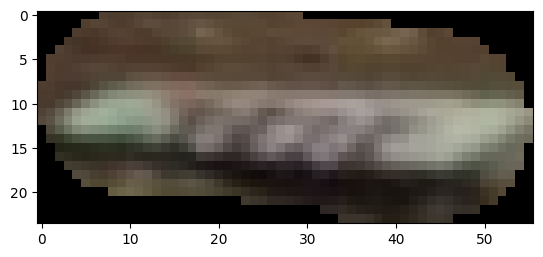

In [29]:
plt.imshow(plt.imread(crops[22]))

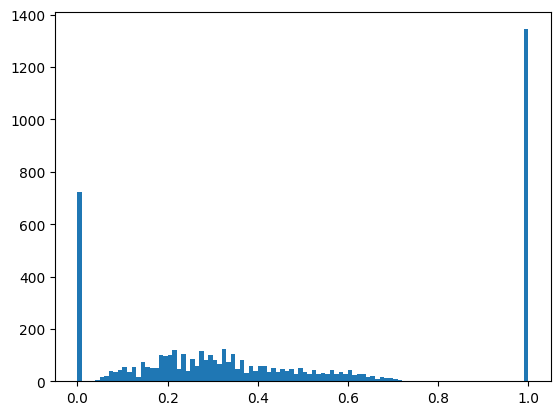

In [33]:
plt.hist(plt.imread(crops[22]).flat, bins=100)
plt.show()

In [ ]:
def mask_from_border_color(bgr_img):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

    h, w = hsv.shape[:2]
    border = np.concatenate([
        hsv[0:10, :, :].reshape(-1, 3),
        hsv[-10:, :, :].reshape(-1, 3),
        hsv[:, 0:10, :].reshape(-1, 3),
        hsv[:, -10:, :].reshape(-1, 3),
    ])

    mean = border.mean(axis=0)
    std = border.std(axis=0)

    lower = mean - 2 * std
    upper = mean + 2 * std

    lower = np.clip(lower, [0, 0, 0], [180, 255, 255])
    upper = np.clip(upper, [180, 255, 255], [180, 255, 255])

    mask = cv2.inRange(hsv, lower, upper)

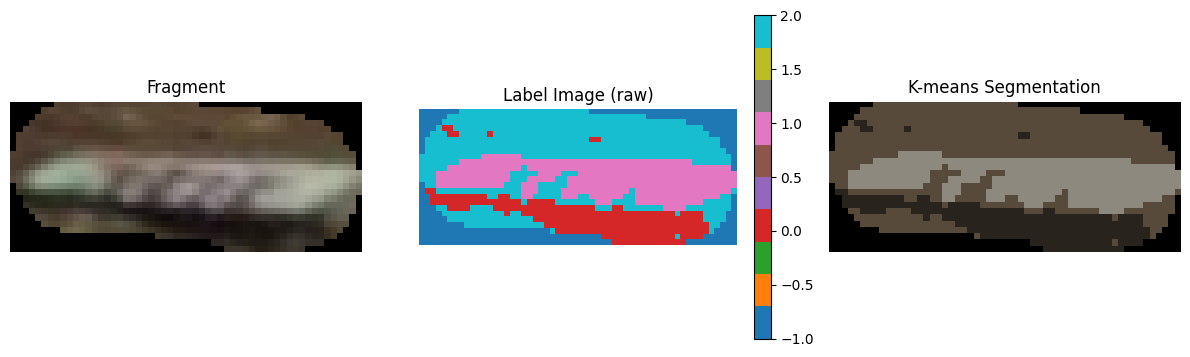

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Load fragment
# --------------------------------------------------
img = cv2.imread(crops[22])
assert img is not None, "Image not found"

h, w = img.shape[:2]

# --------------------------------------------------
# Valid pixel mask (exclude zero padding)
# --------------------------------------------------
valid_mask = np.any(img != 0, axis=2)

# --------------------------------------------------
# K-means on valid pixels only
# --------------------------------------------------
K = 3  # change freely

pixels = img[valid_mask].reshape(-1, 3).astype(np.float32)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)

_, labels, centers = cv2.kmeans(
    pixels,
    K,
    None,
    criteria,
    10,
    cv2.KMEANS_RANDOM_CENTERS
)

# --------------------------------------------------
# Map labels back to image space
# --------------------------------------------------
label_img = np.full((h, w), -1, dtype=np.int32)
label_img[valid_mask] = labels.flatten()

# --------------------------------------------------
# Visualization: each cluster color = its center
# --------------------------------------------------
seg = np.zeros_like(img)

for k in range(K):
    seg[label_img == k] = centers[k].astype(np.uint8)

# Padding stays black
seg[~valid_mask] = 0

# --------------------------------------------------
# Show results
# --------------------------------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Fragment")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Label Image (raw)")
plt.imshow(label_img, cmap="tab10")
plt.colorbar(fraction=0.046)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("K-means Segmentation")
plt.imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

In [107]:
def test_crop(path):
    _, axs = plt.subplots(1, 2, figsize=(20,10))
    axs[0].imshow(plt.imread(path))
    axs[1].imshow(find_background_segment(path))
    plt.show()

In [236]:
import cv2
from mtrain.synth.v1 import copy_at
import numpy as np

def find_background_segment(img_bgr):
    img = img_bgr
    h, w = img.shape[:2]
    valid_mask = np.any(img != 0, axis=2)
    K = 3
    pixels = img[valid_mask].reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _, labels, _ = cv2.kmeans(
        pixels,
        K,
        None,
        criteria,
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )
    label_img = np.full((h, w), -1, dtype=np.int32)
    label_img[valid_mask] = labels.flatten()
    rows, cols = np.where(label_img != -1)
    if len(rows) == 0:
        return None, None, None

    bg_class = label_img[rows[0]][cols[0]]
    invalid_class = -1
    
    return label_img, bg_class, invalid_class


def find_color_similar_regions(
    target_img,
    fragment_img,
    fragment_bg_mask,
    stride_ratio=0.25,
    top_k=5
):

    frag_lab   = cv2.cvtColor(fragment_img, cv2.COLOR_BGR2LAB)
    target_lab = cv2.cvtColor(target_img, cv2.COLOR_BGR2LAB)

    bg_pixels = frag_lab[fragment_bg_mask]

    if bg_pixels.shape[0] == 0:
        raise ValueError("Fragment background mask is empty")

    bg_pixels = bg_pixels.astype(np.float32)

    mean = bg_pixels.mean(axis=0)
    cov  = np.cov(bg_pixels.T) + 1e-6 * np.eye(3)
    cov_inv = np.linalg.inv(cov)

    fh, fw = fragment_img.shape[:2]
    stride_y = max(1, int(fh * stride_ratio))
    stride_x = max(1, int(fw * stride_ratio))

    H, W = target_lab.shape[:2]
    results = []

    for y in range(0, H - fh + 1, stride_y):
        for x in range(0, W - fw + 1, stride_x):

            patch = target_lab[y:y+fh, x:x+fw]
            pixels = patch.reshape(-1, 3).astype(np.float32)

            # Mahalanobis distance (mean over pixels)
            diff = pixels - mean
            d = np.sqrt(np.sum(diff @ cov_inv * diff, axis=1))
            score = d.mean()

            results.append({
                "y0": y,
                "x0": x,
                "y1": y + fh,
                "x1": x + fw,
                "score": float(score)
            })
    results.sort(key=lambda r: r["score"])
    return results[:top_k]

def draw_matches(target_img, matches):
    vis = target_img.copy()

    for m in matches:
        cv2.rectangle(
            vis,
            (m["x0"], m["y0"]),
            (m["x1"], m["y1"]),
            (0, 255, 0),
            2
        )
    return vis


def superpose_matches(img_bgr, frag_bgr, matches):
    img = img_bgr.copy()
    if not matches:
        return img
    match = matches[0]
    copy_at(img, frag_bgr, match["y0"], match["x0"])
    return img

In [237]:
def get_include_class(lbl, include):
    return np.isin(lbl, include)

def get_exclude_class(lbl, exclude):
    return ~np.isin(lbl, exclude)

In [266]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def similarity_hmap(bgr_img, bgr_fragment):

    # -----------------------------
    # Load images
    # -----------------------------
    fragment = bgr_fragment
    image = bgr_img

    # Convert to grayscale for similarity
    fragment_gray = cv2.cvtColor(fragment, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h_frag, w_frag = fragment_gray.shape

    # -----------------------------
    # Sliding window with stride
    # -----------------------------
    stride = 10  # pixels
    heatmap = np.zeros((image_gray.shape[0] - h_frag + 1, image_gray.shape[1] - w_frag + 1))

    for y in range(0, image_gray.shape[0] - h_frag + 1, stride):
        for x in range(0, image_gray.shape[1] - w_frag + 1, stride):
            window = image_gray[y:y+h_frag, x:x+w_frag]
            # TM_CCOEFF_NORMED gives similarity in [-1, 1], higher = better
            score = cv2.matchTemplate(window, fragment_gray, cv2.TM_CCOEFF_NORMED)[0][0]
            heatmap[y, x] = score

    # Normalize heatmap for visualization
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # -----------------------------
    # Find top matches
    # -----------------------------
    num_top_matches = 5
    top_indices = np.unravel_index(np.argsort(heatmap.ravel())[-num_top_matches:], heatmap.shape)

    # Draw rectangles on original image
    output_image = image.copy()
    for y, x in zip(*top_indices):
        top_left = (x, y)
        bottom_right = (x + w_frag, y + h_frag)
        cv2.rectangle(output_image, top_left, bottom_right, (0, 0, 255), 2)

    # -----------------------------
    # Show results
    # -----------------------------
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.title("Similarity Heatmap")
    plt.imshow(heatmap_norm, cmap='hot')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title("Top Matches")
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

    plt.show()

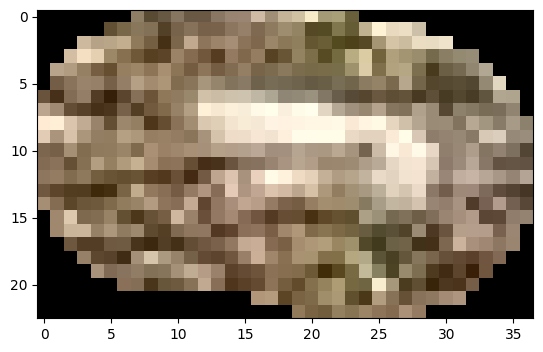

In [278]:
plt.imshow(plt.imread(crops[4]))

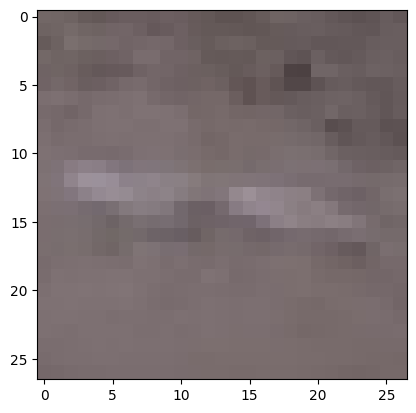

In [282]:
f = "/Users/hariomnarang/Desktop/gbg.png"
plt.imshow(plt.imread(f))

In [295]:
from mtrain.synth.v1 import random_copy

bgi = cv2.imread(p)
fgi = cv2.imread(f)
s0, e0, s1, e1 = random_copy(bgi,fgi)

bgi = cv2.rectangle(bgi, (s1,s0), (e1,e0), (255, 0, 0))

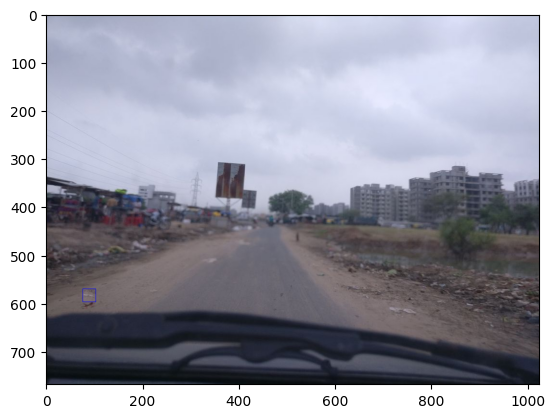

In [296]:
plt.imshow(cv2.cvtColor(bgi, cv2.COLOR_BGR2RGB))

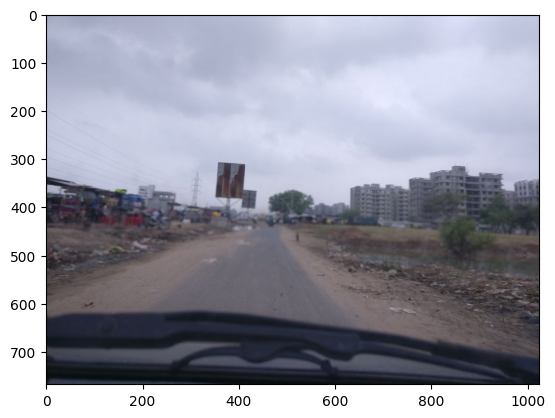

In [ ]:
p = "/Users/hariomnarang/Desktop/personal/roads/datasets/samples_mapillary/ahmedabad/images/252987033288051.jpg" 
plt.imshow(plt.imread(p))

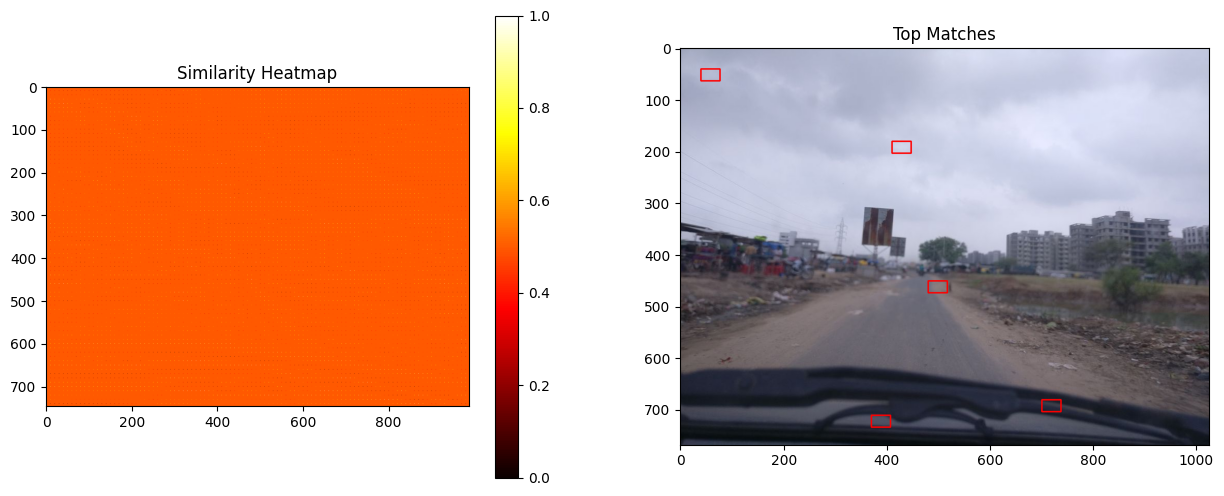

In [279]:
similarity_hmap(
    cv2.imread("/Users/hariomnarang/Desktop/personal/roads/datasets/samples_mapillary/ahmedabad/images/252987033288051.jpg"),
    cv2.imread(crops[4])
)

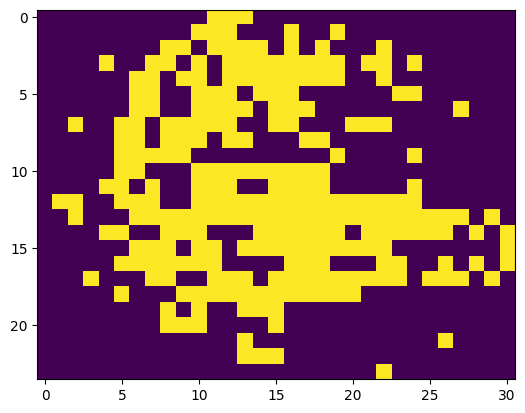

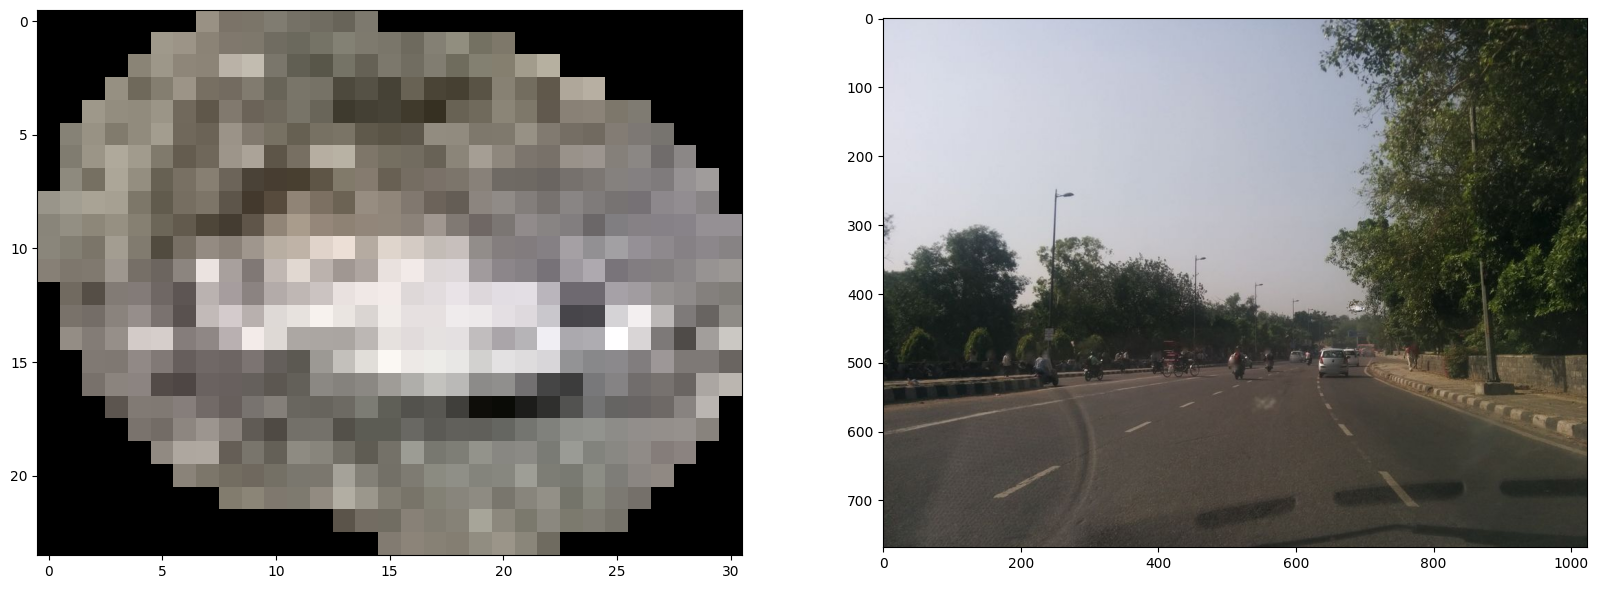

In [264]:
fg = cv2.imread(crops[30])
bgi = cv2.imread(clean_images[11])

lbl_img, bg_cls, inv_cls  = find_background_segment(fg)
regions = find_color_similar_regions(bgi.copy(), fg, get_include_class(lbl_img, bg_cls))

obj_mask_rm = get_include_class(lbl_img, [bg_cls, inv_cls])
plt.imshow(~obj_mask_rm)
tfg = fg.copy()
tfg[obj_mask_rm] = 0
sposed = superpose_matches(bgi, tfg, regions)
final = draw_matches(sposed, regions)

f, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].imshow(cv2.cvtColor(fg, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(sposed, cv2.COLOR_BGR2RGB))
plt.show()

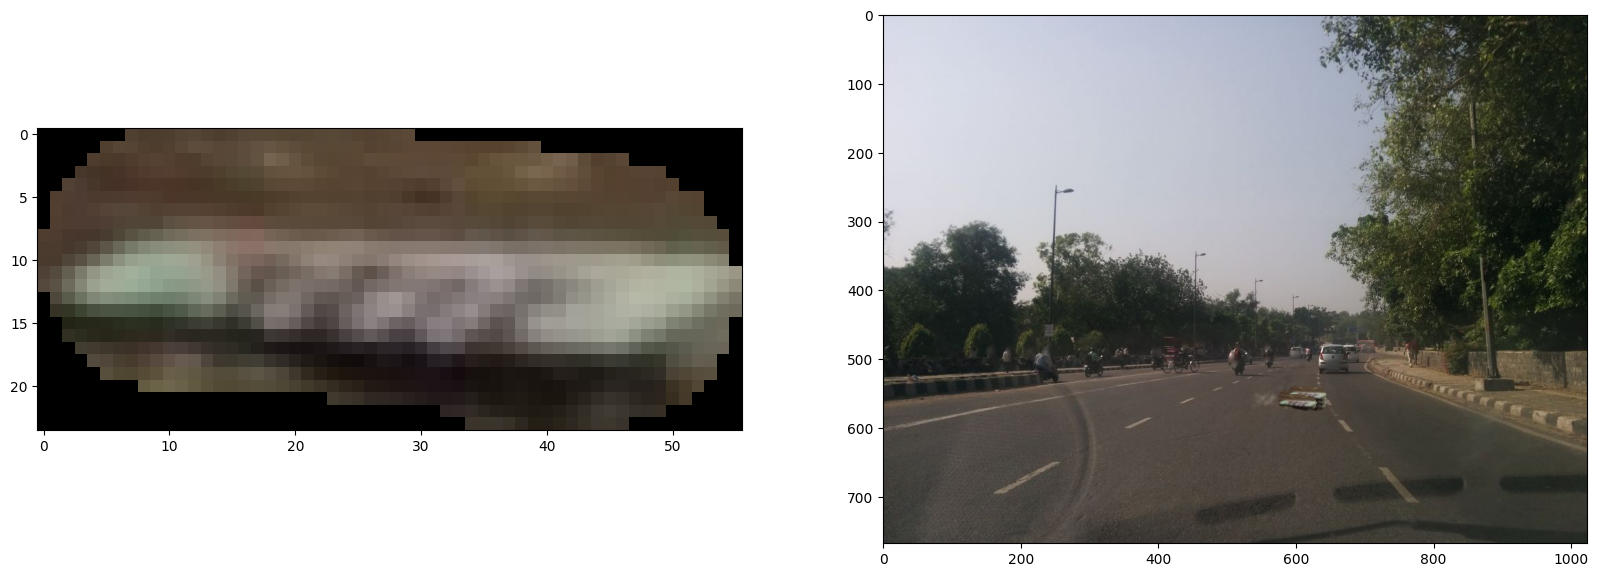

In [ ]:
# rectangle code
cv2.rectangle(
    img_rect,
    pt1,
    pt2,
    color=(0, 255, 0),  # green
    thickness=2        # -1 for filled
)

In [44]:
label_img[0][0]

np.int32(-1)

In [43]:
[i for i in label_img.flatten() if i != -1]

[np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.int32(2),
 np.in

In [300]:
from mtrain.yolo.predict import predict_image
from ultralytics import YOLO

model = YOLO("./best.pt")

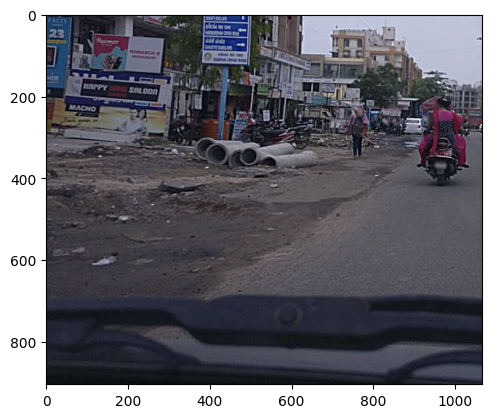

In [306]:
image = cv2.imread("/Users/hariomnarang/Desktop/test-img.png")
image = np.float32(image) 

# Apply Gaussian blur
# Adjust kernel size and sigma for different results
blurred = cv2.GaussianBlur(image, (0, 0), 3) 
amount = 1.5 # Adjust the 'amount' of sharpening
sharpened_image = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)

# Clip the pixel values to be within the valid range [0, 255] and convert back to uint8
sharpened_image = np.clip(sharpened_image, 0, 255)
sharpened_image = np.uint8(sharpened_image)
sharp = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB)
plt.imshow(sharp)

# kernel = np.array([[-1, -1, -1],
#                    [-1,  9, -1],
#                    [-1, -1, -1]])

# # Apply the kernel to the image using cv2.filter2D()
# # The -1 indicates that the output image will have the same depth as the input image
# sharpened_image = cv2.filter2D(image, -1, kernel)
# sharp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# # cv.GaussianBlur(frame, image, cv::Size(0, 0), 3);
# # cv.addWeighted(frame, 1.5, image, -0.5, 0, image);
# plt.imshow(sharp)

1


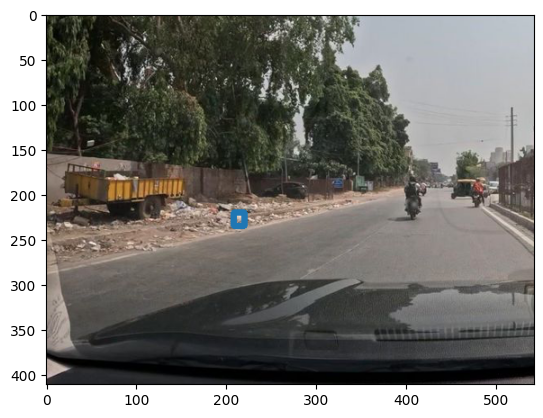

In [312]:
image = cv2.cvtColor(cv2.imread("/Users/hariomnarang/Desktop/gbg4.png"), cv2.COLOR_BGR2RGB)
plt.imshow(predict_image(model, image))